### Load data

In [1]:
# !pip install -U kaleido

In [2]:
import plotly.io as pio

png_renderer = pio.renderers["png"]
png_renderer.width = 1500
png_renderer.height = 700
pio.renderers.default = "png"
pio.templates.default = "plotly_white"

In [7]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve
from scipy.stats import ks_2samp
from tensorflow.keras.utils import to_categorical
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

df_train = pd.read_csv("train_processed.csv")
df_val = pd.read_csv("val_processed.csv")
df_test = pd.read_csv("test_processed.csv")

In [8]:
df_train.head()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,not_satisfied_client,Gender_Female,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus
0,0.205128,0.085622,0.4,0.8,1.0,0.6,0.4,1.0,0.2,0.4,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.371795,0.104806,0.6,0.4,0.4,0.4,0.4,0.4,0.4,0.4,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2,0.358974,0.338853,0.8,0.6,0.8,0.4,0.2,0.8,0.2,0.2,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.551282,0.343700,0.4,0.6,0.6,0.2,0.6,0.4,0.6,0.6,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
4,0.179487,0.142165,0.2,0.8,0.2,0.2,0.4,0.2,0.4,0.4,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [10]:
X_train = df_train.drop('not_satisfied_client', axis=1)
y_train = df_train['not_satisfied_client']

X_val = df_val.drop('not_satisfied_client', axis=1)
y_val = df_val['not_satisfied_client']

X_test = df_test.drop('not_satisfied_client', axis=1)
y_test = df_test['not_satisfied_client']

### Experiments

In [11]:
def build_model(num_layers=2, num_neurons=256, learning_rate=0.001, activation='relu', regularization=None, dropout_rate=0.0, optimizer='adam'):
    model = Sequential()
    model.add(InputLayer(input_shape=(27,)))  # Updated input shape to 27 features

    # Adding hidden layers
    for _ in range(num_layers):
        if regularization == 'l2':
            model.add(Dense(num_neurons, activation=activation, kernel_regularizer=l2(0.01)))
        else:
            model.add(Dense(num_neurons, activation=activation))

        # Adding dropout
        if dropout_rate > 0.0:
            model.add(Dropout(dropout_rate))

    model.add(Dense(10, activation='softmax'))

    # Choosing the optimizer
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    else:
        opt = SGD(learning_rate=learning_rate)

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=[CategoricalAccuracy(), Precision(), Recall()])

    return model

In [12]:
def evaluate_model(y_test, y_pred):
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate precision, recall, and f1-score
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Calculate AUROC
    auroc = roc_auc_score(y_test, y_pred, multi_class='ovr')

    # Calculate Kolmogorov-Smirnov (KS) test
    group_0 = y_pred[y_test == 0]
    group_1 = y_pred[y_test == 1]

    # Perform the KS test
    ks_statistic, p_value = ks_2samp(group_0, group_1)

    return accuracy, precision, recall, f1, auroc, ks_statistic

In [13]:
experiments = [
    {"num_layers": 1, "num_neurons": 64, "learning_rate": 0.001, "activation": 'relu', "regularization": None, "dropout_rate": 0.0, "optimizer": 'adam'},
    {"num_layers": 3, "num_neurons": 128, "learning_rate": 0.001, "activation": 'relu', "regularization": None, "dropout_rate": 0.0, "optimizer": 'adam'},
    {"num_layers": 2, "num_neurons": 256, "learning_rate": 0.001, "activation": 'relu', "regularization": None, "dropout_rate": 0.0, "optimizer": 'adam'},
    {"num_layers": 2, "num_neurons": 128, "learning_rate": 0.0001, "activation": 'relu', "regularization": None, "dropout_rate": 0.0, "optimizer": 'adam'},
    {"num_layers": 2, "num_neurons": 128, "learning_rate": 0.001, "activation": 'relu', "regularization": 'l2', "dropout_rate": 0.0, "optimizer": 'adam'},
    {"num_layers": 2, "num_neurons": 128, "learning_rate": 0.001, "activation": 'relu', "regularization": None, "dropout_rate": 0.5, "optimizer": 'adam'},
    {"num_layers": 2, "num_neurons": 128, "learning_rate": 0.001, "activation": 'tanh', "regularization": None, "dropout_rate": 0.0, "optimizer": 'adam'},
    {"num_layers": 2, "num_neurons": 128, "learning_rate": 0.001, "activation": 'relu', "regularization": None, "dropout_rate": 0.0, "optimizer": 'sgd'},
    {"num_layers": 4, "num_neurons": 128, "learning_rate": 0.001, "activation": 'relu', "regularization": 'l2', "dropout_rate": 0.5, "optimizer": 'adam'},
    {"num_layers": 3, "num_neurons": 256, "learning_rate": 0.0001, "activation": 'tanh', "regularization": 'l2', "dropout_rate": 0.5, "optimizer": 'adam'}
]

In [14]:
results = []

best_ks_stat = -1
best_model = None

y_train_encoded = to_categorical(y_train, num_classes=10)
y_val_encoded = to_categorical(y_val, num_classes=10)

for idx, config in enumerate(experiments):
    model = build_model(**config)
    history = model.fit(X_train, y_train_encoded, validation_data=(X_val, y_val_encoded), epochs=20, batch_size=128, verbose=0)
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    accuracy, precision, recall, f1, auroc, ks_stat = evaluate_model(y_test, y_pred)
    results.append((idx + 1, config, accuracy, precision, recall, f1, auroc, ks_stat))

    if ks_stat > best_ks_stat:
        best_ks_stat = ks_stat
        best_model = model

812/812 [==============================] - 2s 2ms/step


In [15]:
results_df = pd.DataFrame(results, columns=['Experiment', 'Config', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUROC', 'KS'])
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

styled_df = results_df.style.apply(highlight_max, subset=['Accuracy', 'Precision', 'Recall', 'F1', 'AUROC', 'KS'])
styled_df

,Experiment,Config,Accuracy,Precision,Recall,F1,AUROC,KS
0,1,"{'num_layers': 1, 'num_neurons': 64, 'learning_rate': 0.001, 'activation': 'relu', 'regularization': None, 'dropout_rate': 0.0, 'optimizer': 'adam'}",0.949684,0.951144,0.946821,0.948693,0.946821,0.893641
1,2,"{'num_layers': 3, 'num_neurons': 128, 'learning_rate': 0.001, 'activation': 'relu', 'regularization': None, 'dropout_rate': 0.0, 'optimizer': 'adam'}",0.959809,0.960543,0.957866,0.959087,0.957866,0.915732
2,3,"{'num_layers': 2, 'num_neurons': 256, 'learning_rate': 0.001, 'activation': 'relu', 'regularization': None, 'dropout_rate': 0.0, 'optimizer': 'adam'}",0.960348,0.961784,0.957860,0.959586,0.957860,0.915720
3,4,"{'num_layers': 2, 'num_neurons': 128, 'learning_rate': 0.0001, 'activation': 'relu', 'regularization': None, 'dropout_rate': 0.0, 'optimizer': 'adam'}",0.946797,0.946851,0.945039,0.945886,0.945039,0.890078
4,5,"{'num_layers': 2, 'num_neurons': 128, 'learning_rate': 0.001, 'activation': 'relu', 'regularization': 'l2', 'dropout_rate': 0.0, 'optimizer': 'adam'}",0.941561,0.940685,0.940668,0.940677,0.940668,0.881337
5,6,"{'num_layers': 2, 'num_neurons': 128, 'learning_rate': 0.001, 'activation': 'relu', 'regularization': None, 'dropout_rate': 0.5, 'optimizer': 'adam'}",0.953457,0.953345,0.952091,0.952689,0.952091,0.904181
6,7,"{'num_layers': 2, 'num_neurons': 128, 'learning_rate': 0.001, 'activation': 'tanh', 'regularization': None, 'dropout_rate': 0.0, 'optimizer': 'adam'}",0.955497,0.958200,0.951963,0.954540,0.951963,0.903926
7,8,"{'num_layers': 2, 'num_neurons': 128, 'learning_rate': 0.001, 'activation': 'relu', 'regularization': None, 'dropout_rate': 0.0, 'optimizer': 'sgd'}",0.865299,0.865215,0.860558,0.862452,0.860558,0.721117
8,9,"{'num_layers': 4, 'num_neurons': 128, 'learning_rate': 0.001, 'activation': 'relu', 'regularization': 'l2', 'dropout_rate': 0.5, 'optimizer': 'adam'}",0.935594,0.936585,0.932613,0.934340,0.932613,0.865226
9,10,"{'num_layers': 3, 'num_neurons': 256, 'learning_rate': 0.0001, 'activation': 'tanh', 'regularization': 'l2', 'dropout_rate': 0.5, 'optimizer': 'adam'}",0.871997,0.875063,0.865050,0.868526,0.865050,0.730100


### Analysis pos-hoc

In [26]:
y_pred = best_model.predict(X_test)[:, 1]

812/812 [==============================] - 2s 3ms/step


In [30]:
# fixes much clients with same output

import numpy as np
y_pred += np.random.normal(scale=1e-5, size=len(y_pred))


In [31]:
def plot_target_vs_score(target, scores, quantiles, lower_limit=None):
    eval_df = pd.DataFrame(zip(target, scores), columns=['TARGET', 'SCORE']).sort_values(by='SCORE')

    quantile = pd.qcut(eval_df['SCORE'], quantiles, labels=range(1,1+quantiles))
    eval_df['QUANTILE'] = quantile
    if lower_limit:
        eval_df = eval_df.loc[eval_df['QUANTILE'] > lower_limit]

    chart_df = pd.DataFrame(zip(
      eval_df.groupby('QUANTILE')['TARGET'].mean(), eval_df.groupby('QUANTILE')['TARGET'].size()/eval_df.shape[0]
      ), columns=['TAXA_DE_MAUS', 'POPULACAO'])

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    chart_df = chart_df.dropna()
    # Add traces
    fig.add_trace(
      go.Bar(x=chart_df.index.to_list(), y=chart_df.POPULACAO, name="Representatividade (%)", marker_color='rgba(0, 0, 87, .8)'),
      secondary_y=False,
    )

    fig.add_trace(
      go.Scatter(x=chart_df.index.to_list(), y=chart_df.TAXA_DE_MAUS, name="Média do alvo ponderada pela exposição (%)", marker_color='red'),
      secondary_y=True,
      #labels=dict(x="Decil", y="Representatividade (%)")
    )

    fig.update_xaxes(title_text='Decil da população')
    fig.update_yaxes(title_text='Representatividade (%)', secondary_y=False)
    fig.update_yaxes(title_text='Média do alvo ponderada pela exposição (%)', secondary_y=True)
    fig.update_layout(
      width=1000,height=500,
      legend=dict(orientation="h", xanchor='center', x=0.5, y=-0.2))

    fig.show()

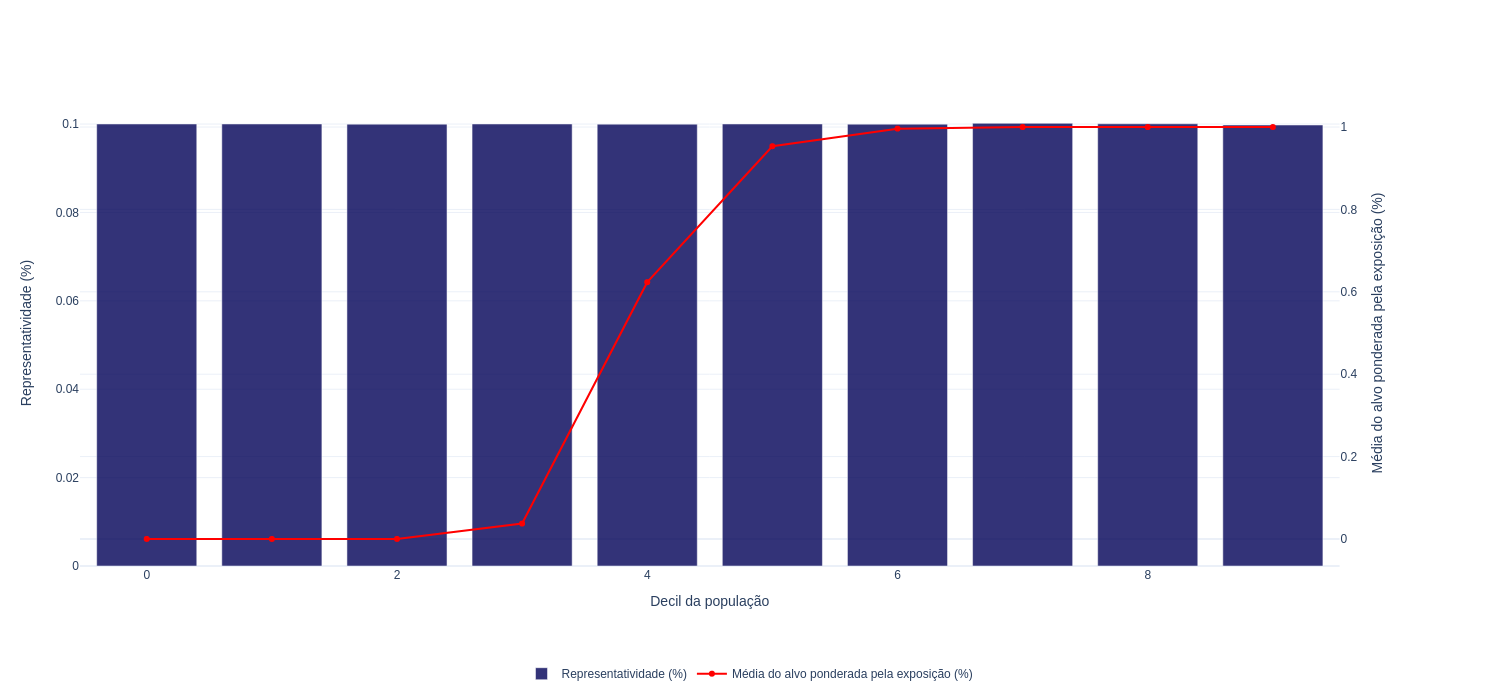

In [32]:
plot_target_vs_score(y_test, y_pred, 10)

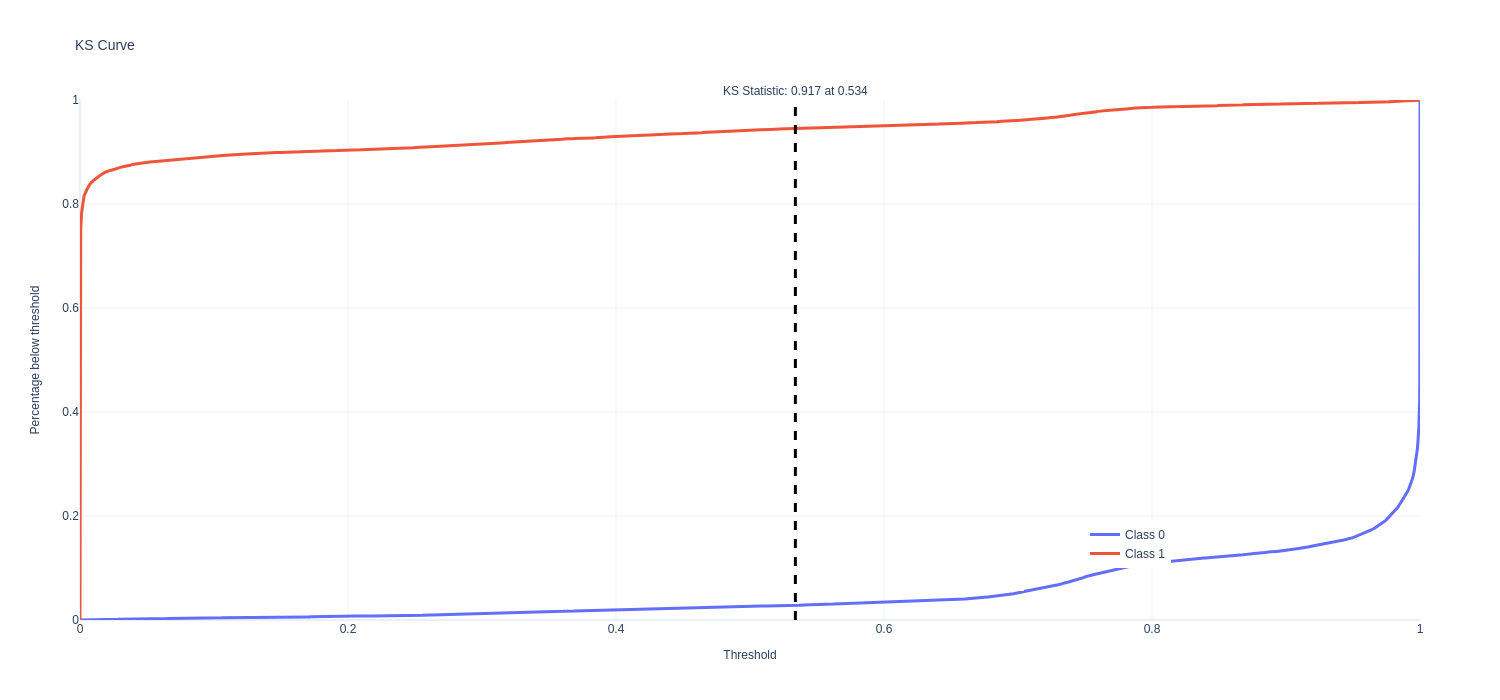

In [33]:
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import roc_curve

def binary_ks_curve(y_true, y_probas):
    # Sort probabilities and true values
    sorted_indices = np.argsort(y_probas)
    sorted_probas = y_probas[sorted_indices]
    sorted_true = y_true[sorted_indices]

    # Compute the cumulative percentage of positives and negatives
    cum_pos = np.cumsum(sorted_true) / np.sum(sorted_true)
    cum_neg = np.cumsum(1 - sorted_true) / np.sum(1 - sorted_true)

    thresholds = np.concatenate([[0], sorted_probas, [1]])
    pct1 = np.concatenate([[0], cum_pos, [1]])
    pct2 = np.concatenate([[0], cum_neg, [1]])

    ks_statistic = np.max(np.abs(pct1 - pct2))
    max_distance_at = thresholds[np.argmax(np.abs(pct1 - pct2))]

    return thresholds, pct1, pct2, ks_statistic, max_distance_at, [0, 1]

def plot_ks_curve(y_true, y_probas, title='KS Curve', title_fontsize=14, text_fontsize=12):
    y_true = np.array(y_true)
    y_probas = np.array(y_probas)

    classes = np.unique(y_true)
    if len(classes) != 2:
        raise ValueError('Cannot calculate KS statistic for data with '
                         '{} category/ies'.format(len(classes)))
    probas = y_probas

    # Compute KS Statistic curves
    thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(y_true, probas.ravel())

    # Create the plotly figure
    fig = go.Figure()

    # Add the percentage below threshold for each class
    fig.add_trace(go.Scatter(x=thresholds, y=pct1, mode='lines', name=f'Class {classes[0]}', line=dict(width=3)))
    fig.add_trace(go.Scatter(x=thresholds, y=pct2, mode='lines', name=f'Class {classes[1]}', line=dict(width=3)))

    # Add the KS Statistic line
    idx = np.where(thresholds == max_distance_at)[0][0]
    fig.add_vline(x=max_distance_at, line_width=3, line_dash='dash', line_color='black',
                  annotation_text=f'KS Statistic: {ks_statistic:.3f} at {max_distance_at:.3f}',
                  annotation_position='top', annotation_font_size=text_fontsize)

    # Update layout
    fig.update_layout(
        title=title, title_font_size=title_fontsize,
        xaxis_title='Threshold', xaxis_title_font_size=text_fontsize,
        yaxis_title='Percentage below threshold', yaxis_title_font_size=text_fontsize,
        xaxis=dict(range=[0.0, 1.0]),
        yaxis=dict(range=[0.0, 1.0]),
        legend=dict(x=0.75, y=0.1, font_size=text_fontsize),
        font=dict(size=text_fontsize)
    )

    return fig

fig = plot_ks_curve(list(y_test), list(y_pred), title='KS Curve')
fig.show()

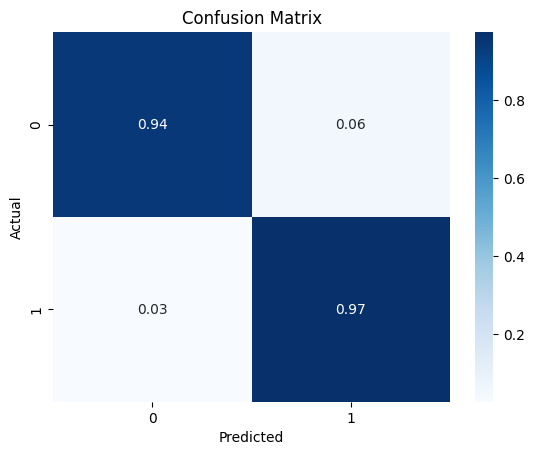

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get confusion matrix
cm = confusion_matrix(y_test, (y_pred > 0.5).astype("int"))
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

# Create heatmap
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues")

# Set labels and title
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Show plot
plt.show()


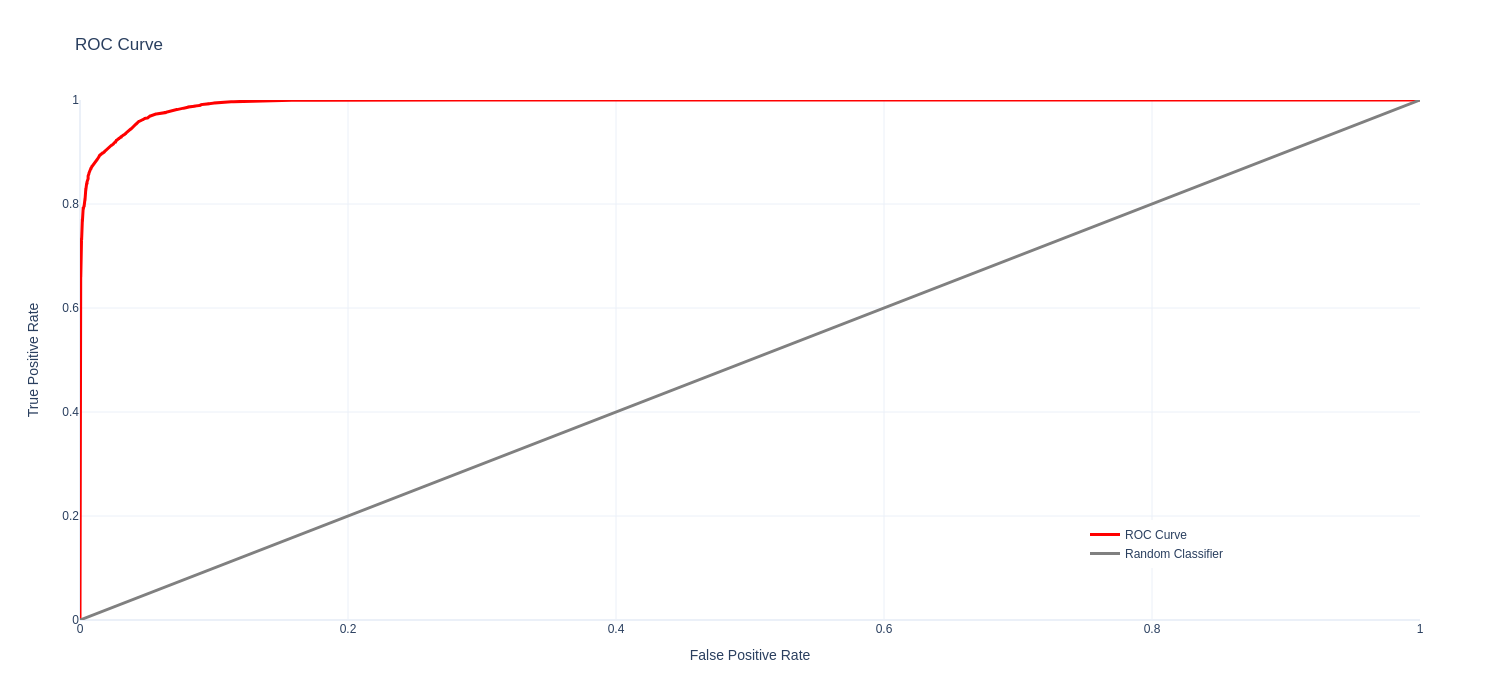

In [37]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Create plotly figure
fig = go.Figure()

# Add ROC curve trace
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC Curve', line=dict(color='red', width=3)))

# Add diagonal line
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random Classifier', line=dict(color='grey', width=3)))

# Add annotations

# Update layout
fig.update_layout(
    title='ROC Curve',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    xaxis=dict(range=[0.0, 1.0]),
    yaxis=dict(range=[0.0, 1.0]),
    legend=dict(x=0.75, y=0.1),
    font=dict(size=12),
    width=600,
    height=600
)

# Show plot
fig.show()
